Author: Michael Gygli ([Github](https://github.com/gyglim), [Twitter](https://twitter.com/GygliMichael)), 2016-01-13 

# Introduction #

This example demonstrates how to compute *C3D convolutional features* using Lasagne and Theano. C3D can be used as a general video feature and has shown strong performance. You can find more information in the paper [1] or the caffe-based reference implementation [2].
* [1]: D. Tran, L. Bourdev, R. Fergus, L. Torresani, and M. Paluri, Learning Spatiotemporal Features with 3D Convolutional Networks, ICCV 2015, http://vlg.cs.dartmouth.edu/c3d/c3d_video.pdf
* [2]: http://vlg.cs.dartmouth.edu/c3d/

# Preparation steps #

This demo uses the pretrained C3D weights, as well as the c3d module in the Lasagne Recipes modelzoo. Thus, you will need to get the Recipes from github (https://github.com/Lasagne/Recipes) first.


In [1]:
# Import models and set path
import sys
model_dir='../modelzoo/' # Path to your recipes/modelzoo
sys.path.insert(0,model_dir)
import c3d
import lasagne
import theano

Using gpu device 0: Tesla K20Xm (CNMeM is disabled)
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '237725' (I am process '241062')


In [2]:
# Download the weights and mean of the model
!wget -N https://data.vision.ee.ethz.ch/gyglim/C3D/c3d_model.pkl
!wget -N https://data.vision.ee.ethz.ch/gyglim/C3D/snipplet_mean.npy    
    
# And the classes of Sports1m
!wget -N https://data.vision.ee.ethz.ch/gyglim/C3D/labels.txt

# Finally, an example sniplet
!wget -N https://data.vision.ee.ethz.ch/gyglim/C3D/example_snip.npy

--2016-01-13 15:41:24--  https://data.vision.ee.ethz.ch/gyglim/C3D/c3d_model.pkl
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913178688 (871M)
Server file no newer than local file `c3d_model.pkl' -- not retrieving.

--2016-01-13 15:41:25--  https://data.vision.ee.ethz.ch/gyglim/C3D/snipplet_mean.npy
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8405088 (8.0M)
Server file no newer than local file `snipplet_mean.npy' -- not retrieving.

--2016-01-13 15:41:25--  https://data.vision.ee.ethz.ch/gyglim/C3D/labels.txt
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.v

In [3]:
# Build model
net = c3d.build_model()

# Set the weights (takes some time)
c3d.set_weights(net['prob'],'c3d_model.pkl')

Load pretrained weights from c3d_model.pkl...
Set the weights...


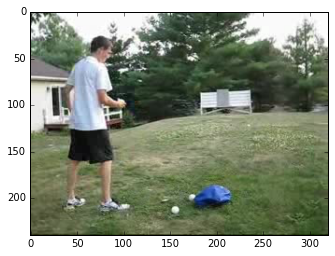

In [4]:
# Load the video snipplet and show an example frame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
snip=np.load('example_snip.npy')
plt.imshow(snip[0,:,:,:])

In [5]:
# Convert the video snipplet to the right format
# i.e. (nr in batch, channel, frameNr, y, x) and substract mean
caffe_snip=c3d.get_snips(snip,image_mean=np.load('snipplet_mean.npy'),start=0, with_mirrored=False)

In [6]:
# Compile prediction function
prediction = lasagne.layers.get_output(net['prob'], deterministic=True)
pred_fn = theano.function([net['input'].input_var], prediction, allow_input_downcast = True); 

In [7]:
# Now we can get a prediction
probabilities=pred_fn(caffe_snip).mean(axis=0) # As we average over flipped and non-flipped

In [8]:
# Load labels
with open('labels.txt','r') as f:
    class2label=dict(enumerate([name.rstrip('\n') for name in f]))
    
# Show the post probable ones
print('Top 10 class probabilities:')
for class_id in (-probabilities).argsort()[0:10]:
    print('%20s: %.2f%%' % (class2label[class_id],100*probabilities[class_id]))

Top 10 class probabilities:
         wiffle ball: 29.87%
      knife throwing: 13.12%
             croquet: 11.36%
           disc golf: 5.30%
            kickball: 5.15%
            rounders: 4.48%
               bocce: 3.53%
           dodgeball: 2.25%
           boomerang: 1.71%
            tee ball: 1.39%


#### Comparison to C3D reference implementation ####
For this example, the Top 10 probabilities of the original C3D implementation are:

         wiffle ball: 29.91%
      knife throwing: 13.11%
             croquet: 11.27%
           disc golf: 5.29%
            kickball: 5.18%
            rounders: 4.48%
               bocce: 3.53%
           dodgeball: 2.27%
           boomerang: 1.71%
            tee ball: 1.39%

